# 0809CNN模型训练

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydot_ng as pydot
import math
import tensorflow as tf
import keras
import catboost as cb
from pandas import read_csv
from math import sqrt
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM,Flatten,Conv1D,MaxPooling1D
from keras.utils import np_utils,plot_model
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import svm
from keras.layers.core import Dense, Activation, Dropout
from sklearn.externals import joblib
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:472: FutureWarning: Passi

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto(allow_soft_placement = True)
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.7)
config.gpu_options.allow_growth = True
sess0 = tf.InteractiveSession(config = config)

In [3]:
print(os.getcwd()) # 打印当前工作目录

E:\Research Project\DKASC, Alice Springs


In [4]:
os.listdir(os.getcwd())

['.idea',
 '.ipynb_checkpoints',
 '101-Site_DKA-WeatherStation',
 '96-Site_DKA-MasterMeter1',
 'Alice_Springs_2016-2020',
 'CNN模型训练0809.ipynb',
 'Dataset',
 'logs',
 'picture',
 'Predict',
 'Program backups',
 'temp',
 'venv',
 '数据集_小波包分解重构数据.ipynb',
 '数据集_预处理_第二版0702.ipynb',
 '测试小波分解.ipynb',
 '测试模型0622.ipynb',
 '测试模型0704.ipynb',
 '测试模型0704批量.ipynb',
 '测试模型小波包分解0704批量.ipynb',
 '画图.ipynb',
 '画图0704.ipynb',
 '笔记.ipynb',
 '训练模型0622.ipynb',
 '训练模型0702.ipynb',
 '训练模型0703 WPD.ipynb']

In [5]:
os.chdir("./Dataset")

In [6]:
os.listdir()

['DKA.Station_1-9.csv',
 'NaN_DKA.Station.csv',
 'raw_DKA.Station_1-9.csv',
 'test',
 'test0702',
 'testdata.csv',
 'testWPD',
 'test_1A.csv',
 'train',
 'train0702',
 'traindata.csv',
 'trainWPD',
 'train_1A.csv',
 '测试集8个站点.csv',
 '训练集8个站点.csv']

In [7]:
train = pd.read_csv('./train0702/train_Station_4.csv')
test = pd.read_csv('./test0702/test_Station_4.csv')

In [8]:
#查看输入数据维度
print(train.shape)
print(test.shape)

(314843, 13)
(102888, 13)


In [9]:
train.head(5)

,Timestamp,Year,Month,Day,Hour,Minutes,Temperature(°C),Relative Humidity(%),Wind Direction(Degrees),Daily Rainfall(mm),Global Horizontal Radiation(W/m²),Diffuse Horizontal Radiation(W/m²),Station_4
0,2016/1/1 0:00,2016,1,1,0,0,17.176111,87.095665,186.941284,0.0,2.672255,1.103375,0.000400
1,2016/1/1 0:05,2016,1,1,0,5,17.133446,87.671669,191.876770,0.0,2.703700,1.152340,0.000400
2,2016/1/1 0:10,2016,1,1,0,10,17.084999,88.563240,188.268082,0.0,3.013785,1.566642,0.000533
3,2016/1/1 0:15,2016,1,1,0,15,16.955778,90.001663,197.727295,0.0,3.421924,1.707677,0.000067
4,2016/1/1 0:20,2016,1,1,0,20,16.854271,91.222733,193.704559,0.0,3.292158,1.746989,0.000600


In [10]:
test.head(2)

,Timestamp,Year,Month,Day,Hour,Minutes,Temperature(°C),Relative Humidity(%),Wind Direction(Degrees),Daily Rainfall(mm),Global Horizontal Radiation(W/m²),Diffuse Horizontal Radiation(W/m²),Station_4
0,2019/1/1 0:00,2019,1,1,0,0,30.020723,20.125513,32.213470,0.0,1.543787,1.349848,0.000533
1,2019/1/1 0:05,2019,1,1,0,5,29.958653,20.040049,32.158791,0.0,1.373370,1.244123,0.000433


# 准备训练

In [11]:
train.columns

Index(['Timestamp', 'Year', 'Month', 'Day', 'Hour', 'Minutes',
       'Temperature(°C)', 'Relative Humidity(%)', 'Wind Direction(Degrees)',
       'Daily Rainfall(mm)', 'Global Horizontal Radiation(W/m²)',
       'Diffuse Horizontal Radiation(W/m²)', 'Station_4'],
      dtype='object')

In [12]:
train1=train.drop(columns=['Timestamp','Year'])
test1= test.drop(columns=['Timestamp','Year'])

In [13]:
train1.columns

Index(['Month', 'Day', 'Hour', 'Minutes', 'Temperature(°C)',
       'Relative Humidity(%)', 'Wind Direction(Degrees)', 'Daily Rainfall(mm)',
       'Global Horizontal Radiation(W/m²)',
       'Diffuse Horizontal Radiation(W/m²)', 'Station_4'],
      dtype='object')

# 归一化数据

In [14]:
train1 = train1.values
train1 = train1.astype('float32')     # 将整型变为float
scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
train1 = scaler.fit_transform(train1)

test1 = test1.values
test1 = test1.astype('float32')     # 将整型变为float
scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
test1 = scaler.fit_transform(test1)

inds = np.arange(train1.shape[0])
train1_inds = inds[0:int(train1.shape[0]*0.8)]
eval1_inds = inds[int(train1.shape[0]*0.8):train1.shape[0]]


train_X, train_y = train1[train1_inds,:-1], train1[train1_inds,-1:]
eval_X,eval_y = train1[eval1_inds,:-1], train1[eval1_inds,-1:]
test_X, test_y = test1[:, :-1], test1[:,-1:]

train_X = np.expand_dims(train_X, axis=2)#增加一维轴
eval_X = np.expand_dims(eval_X, axis=2)
test_X = np.expand_dims(test_X, axis=2)
# # reshape input to be 3D [samples, timesteps, features]
# train_Xl = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# eval_Xl = eval_X.reshape((eval_X.shape[0],1,eval_X.shape[1]))
# test_Xl = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,eval_X.shape,eval_y.shape, test_X.shape, test_y.shape)
# print(train_Xl.shape, train_y.shape,eval_Xl.shape,eval_y.shape, test_Xl.shape, test_y.shape)

(251874, 10, 1) (251874, 1) (62969, 10, 1) (62969, 1) (102888, 10, 1) (102888, 1)


# Kears模型构建

# CNN模型

In [57]:
model = Sequential()
model.add(Conv1D(16, 2,input_shape=(train_X.shape[1],1), activation='relu'))
# model.add(Conv1D(32, 3, activation='relu'))
# model.add(MaxPooling1D(2))
model.add(Conv1D(64, 2, activation='relu'))
# model.add(Conv1D(16, 2, activation='relu'))
# model.add(MaxPooling1D(2))
# model.add(Conv1D(16, 2, activation='relu'))
# model.add(Conv1D(16, 2, activation='relu'))
# model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(units=64,activation='sigmoid',use_bias = True))
model.add(Dense(units=32,activation='sigmoid',use_bias = True))
model.add(Dense(units=16,activation='sigmoid',use_bias = True))
# model.add(Dense(units=8,name='layer4',activation='sigmoid',use_bias = True))
model.add(Dense(1, activation='sigmoid'))
# plot_model(model, to_file='./model_sig.png', show_shapes=True)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 9, 16)             48        
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 8, 64)             2112      
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total para

In [58]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [59]:
history = model.fit(train_X,train_y, validation_data=(eval_X, eval_y),epochs = 30, batch_size = 1000 )

Train on 251874 samples, validate on 62969 samples
Epoch 1/30
251874/251874 [==============================] - 6s - loss: 0.0507 - mean_absolute_error: 0.1897 - val_loss: 0.0078 - val_mean_absolute_error: 0.0785
Epoch 2/30
251874/251874 [==============================] - 5s - loss: 0.0051 - mean_absolute_error: 0.0563 - val_loss: 0.0034 - val_mean_absolute_error: 0.0471
Epoch 3/30
251874/251874 [==============================] - 6s - loss: 0.0029 - mean_absolute_error: 0.0382 - val_loss: 0.0021 - val_mean_absolute_error: 0.0356
Epoch 4/30
251874/251874 [==============================] - 6s - loss: 0.0021 - mean_absolute_error: 0.0303 - val_loss: 0.0016 - val_mean_absolute_error: 0.0300TA: 4s - loss - ETA: 1s - loss: 0.0022 - me
Epoch 5/30
251874/251874 [==============================] - 5s - loss: 0.0017 - mean_absolute_error: 0.0255 - val_loss: 0.0013 - val_mean_absolute_error: 0.0258
Epoch 6/30
251874/251874 [==============================] - 5s - loss: 0.0015 - mean_absolute_error: 

In [60]:
modelcnn = model
modelcnn.save('../logs/CNN0809.h5')

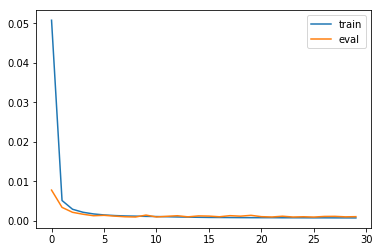

In [61]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

# 反归一化

In [62]:
# test_X.shape

In [63]:
# print(np.squeeze(test_X).shape)

In [64]:
def inv(testPredictML,test_X,test_y):
    test_X = np.squeeze(test_X)
    # invert scaling for forecast
    inv_testPredictML = concatenate((test_X[:,:],testPredictML), axis=1)
    inv_testPredictML = scaler.inverse_transform(inv_testPredictML)
    testPredictML = inv_testPredictML[:,-1:]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_test = concatenate((test_X[:,:],test_y), axis=1)
    inv_test = scaler.inverse_transform(inv_test)
    testReal = inv_test[:,-1:]
    return testPredictML,testReal,inv_test

In [65]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

# 评价指标

In [66]:
# predicted = model.predict(test_X)

In [67]:
cnn_pred = modelcnn.predict(test_X)
# cnn_pred,y_true,inv_test=inv(cnn_pred,test_year,test_X,test_y)
cnn_pred,y_true,inv_test=inv(cnn_pred,test_X,test_y)
# y_true = test_y

cnn_mse = metrics.mean_squared_error(y_true, cnn_pred)
cnn_rmse = math.sqrt(mean_squared_error(y_true[:,0], cnn_pred[:,0]))
cnn_mae = metrics.mean_absolute_error(y_true, cnn_pred)
cnn_mape = mape(y_true, cnn_pred)
cnn_smape = smape(y_true, cnn_pred)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [68]:
print(cnn_mse,cnn_rmse,cnn_mae,cnn_mape,cnn_smape)

0.02143646 0.14641195414371458 0.06791119 inf 103.87102365493774


# 保存预测结果并绘图

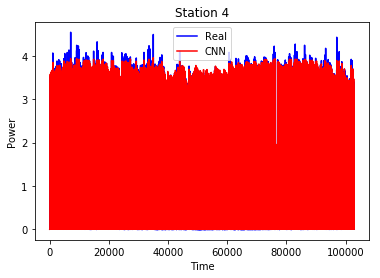

In [69]:
# plt.plot(lstm_pred,'orchid',label='LSTM')
plt.plot(y_true,'b',label='Real')
plt.plot(cnn_pred,'r',label='CNN')

plt.title('Station 4')
plt.ylabel('Power')
plt.xlabel('Time')
plt.legend()
# plt.savefig('../picture/CNN0809.jpg')